# Predicting Heart Disease With Age, Serum Cholesterol, Resting Blood Pressure and Maximum Heart Rate Using Classification Method


In [2]:
download from keggle 
check seeds 
check spellings

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: download from
             ^


## Introduction
Heart disease is a disease that refers to several types of heart conditions, which is the main cause of death in the USA for most of racial and ethnic groups (1). The main risk factors for heart disease are high blood pressure, high blood cholesterol, smoking, and age. Some of the common heart disease symptoms are chest pain, irregular heartbeats (heart beats too fast or too slow or irregularly), Pain in the back, and shortness of breath. A doctor usually diagnose a patients as either healthy or heart diseased based on their risk factors and symptoms; as a result, a doctor may make prediction about heart disease based on the current situation and his or her past experiment. The Heart disease data was downloaded from Kaggle to use for prediction of heart disease. To answer this question, we will use the “Heart Failure Prediction Dataset”. This dataset contains 11 variables, which Age, RestingBP, Cholesterol, MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal).



#### Question: 
   Can we use the Age, normal blood pressure when body is at rest, maximum heart rate achieved, and blood cholesterol level variables to predict if a patient heart disease or not? 
   



## Methods and Results

#### Loading the Libraries 

In [13]:
### Loading Libraries into R
library(tidyverse)
library(tidymodels)
library(cowplot)

library(repr)
options(repr.matrix.max.rows = 6)

#set the seed
set.seed(123) 

#### Loading the Data
The Heart disease data was downloaded from Kaggle as a CSV file and was saved to the 'data' folder.

???? fix it, should not be from kaggle

In [14]:
#Reading data from the "data" folder, no data explaination on the csv file, no need for skipping. 
#data is tidy 
#we read the data into R as "data"
set.seed(123)
heart_data <- read_csv("data/heart.csv")
heart_data

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


#### Variable Explanation 

Age: age of the patient [years]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

HeartDisease:[1: heart disease, 0: Normal]

#### Wrangling & Cleaning the Data
The data is tibble and the `Cholesterol` = 0 is equivalent to NA in this data set. Except`Cholesterol`, all the other variables do not contain NA. We are selecting for these following numerical variables as our predictors for the model: 
age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl).

In [10]:
heart_data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

Cholesterol,n
<dbl>,<int>
0,172


Table 1. Number of missing data for cholestrol variable 

Table 1 suggests that blood cholestrol data of 172 patients is missing, so the data set is filtered to remove `Cholesterol` = 0

In [69]:
#We filter against NA in Cholesterol
heartdisease_data <- heart_data|> 
    filter(Cholesterol!=0)
heartdisease_data

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In the above data set `HeartDisease` was incorrectly stored as a numerical (dbl) column; therefore, we use mutate() to turn it into a factor. 
Then the following variables (`Age`, `RestingBP`, `Cholesterol` and `MaxHR`)
are selected as these are predictors in this model. 

In [70]:
#Convert the character class variable to the factor data type
data_heart <- heartdisease_data|>
        mutate(HeartDisease = as.factor(HeartDisease))|>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
data_heart

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
57,130,131,115,1
57,130,236,174,1
38,138,175,173,0


#### Splitting the Data
Splitting the data into training set and testing 
set using 75% of the data for training. 


We split the data into training and testing set so we can evaluate our model prediction accuracy.

In [71]:
set.seed(123)
heart_split <- initial_split(data_heart, prop = 0.75, strata = HeartDisease) 
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
               
heart_train

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,283,98,0
39,120,339,170,0
45,130,237,170,0
⋮,⋮,⋮,⋮,⋮
45,110,264,132,1
68,144,193,141,1
57,130,131,115,1


##### Finding the ratio of each class of the target variable (0 = Normal, 1 = Diseased) in the training data.

In [46]:
n_row_train <- nrow(heart_train)
data_train_percentage <- heart_train |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row_train*100)

data_train_percentage

HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,292,52.23614
1,267,47.76386


Table 2. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the training data

Table 2 suggests, the distribution of
the target variable classes 0 (normal, 52%) and 1 (diseased, 48%) 
are very close. In other words, half of the observations are normal
and the other half is diseased. This suggests that the dataset is not 
significantly under the influence of one of the classes. 
This helps us to ensure that the model does not show a false accuracy.

#### Distribution Tables

Table summary of the predictors and their numerical distribution (mean and variance) in each class of the target variable (0 = Normal, 1 = Diseased)

In [74]:
nheart <- heart_train |>
        group_by(HeartDisease)|>
        summarize(Observation=n())

table_3 <- heart_train|>
    group_by(HeartDisease)|>
    summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 
mean_heart_disease <- merge(table_3,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)

mean_heart_disease

HeartDisease,Avg_Age,Avg_RestingBP,Avg_Cholesterol,Avg_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,50.48288,130.1918,243.7740,149.2671,292
1,55.95506,136.3296,250.6742,129.3184,267


Table 3. Averages of the predictor variables in the training set 

In [75]:
table_4 <- heart_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_4,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 

variance_heart_disease

HeartDisease,var_Age,var_RestingBP,var_Cholesterol,var_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,93.07531,252.2174,3421.076,528.6500,292
1,77.31376,337.2895,3904.702,466.9547,267


Table 4. Variance of the predictor variables in the training set 

Based on the tables 3 & 4, the Mean and variance of the variables that we
want to use as predictors are not in a similar range.
Therefore, we need standardize our data by scaling 
and centring the variables to have comparable predictors.

#### Standardization 

Standardized predictors will be performed to create comparable predictors with similar mean and variance.

In [77]:
data_train_recipe <- recipe(HeartDisease ~ ., data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    prep()

scaled_heart <- bake(data_train_recipe, heart_train)
scaled_heart

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.6702218,-0.1798122,0.5941202,-1.70717,0
-1.4626970,-0.7554996,1.5201017,1.23772,0
-0.8401227,-0.1798122,-0.1665075,1.23772,0
⋮,⋮,⋮,⋮,⋮
-0.8401227,-1.3311869,0.2799479,-0.31652748,1
1.5464123,0.6261501,-0.8940644,0.05158388,1
0.4050260,-0.1798122,-1.9192582,-1.01184894,1


#### Visualization 

Visualizing the data in order to find any potential correlation between predictors and their effect on the classification of the target variables. 

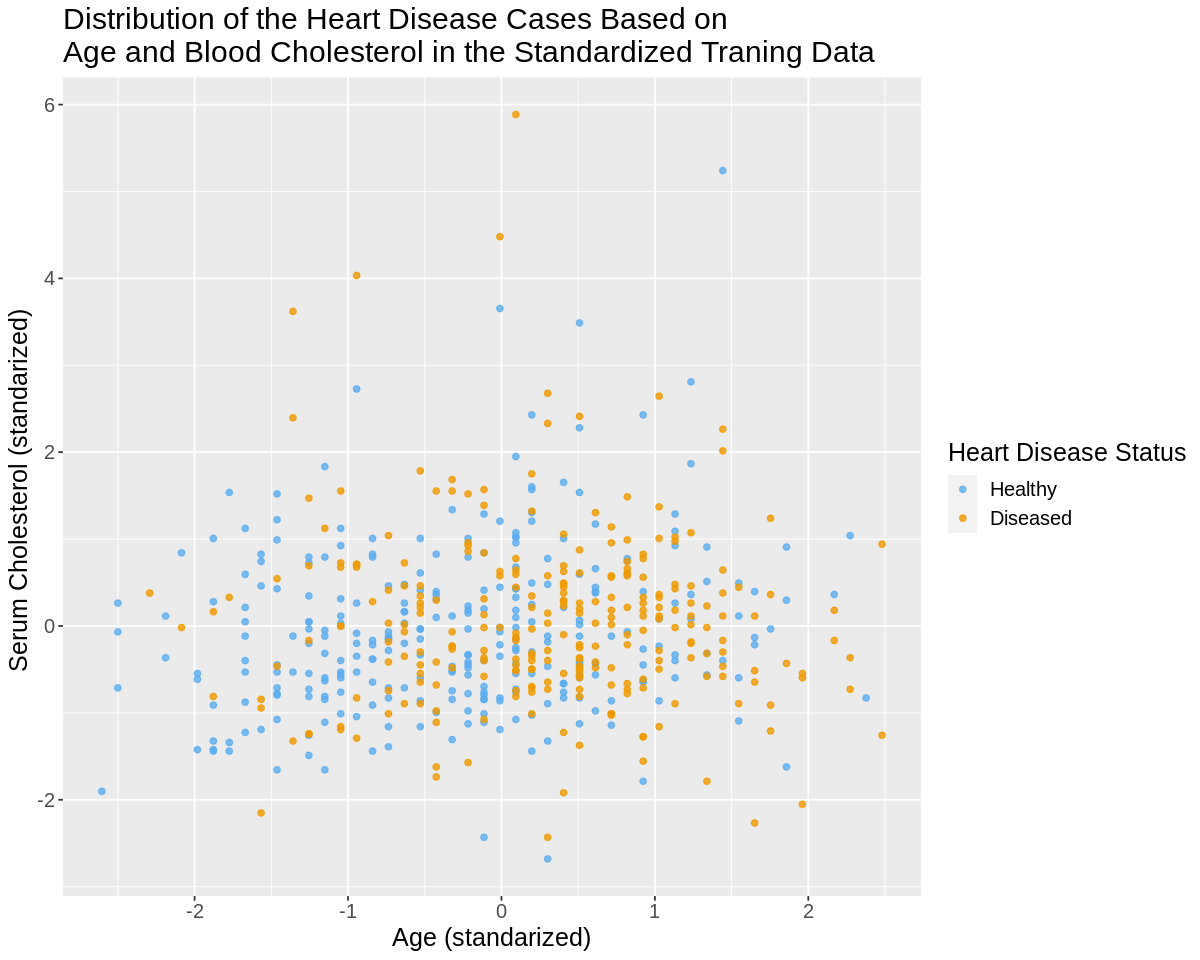

In [78]:
options(repr.plot.width = 10, repr.plot.height = 8) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(scaled_heart, aes(x = Age, y = Cholesterol, color = HeartDisease)) +
      geom_point( alpha = 0.8) +
      xlab("Age (standarized)") +
      ylab("Serum Cholesterol (standarized) ") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on \nAge and Blood Cholesterol in the Standardized Traning Data") 
 agevsbp     

Figure 1: Scatter plot of Serum Cholesterol versus Age colored by heart disease status label

In [51]:
explain the relationship and whta we expect

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain the
            ^


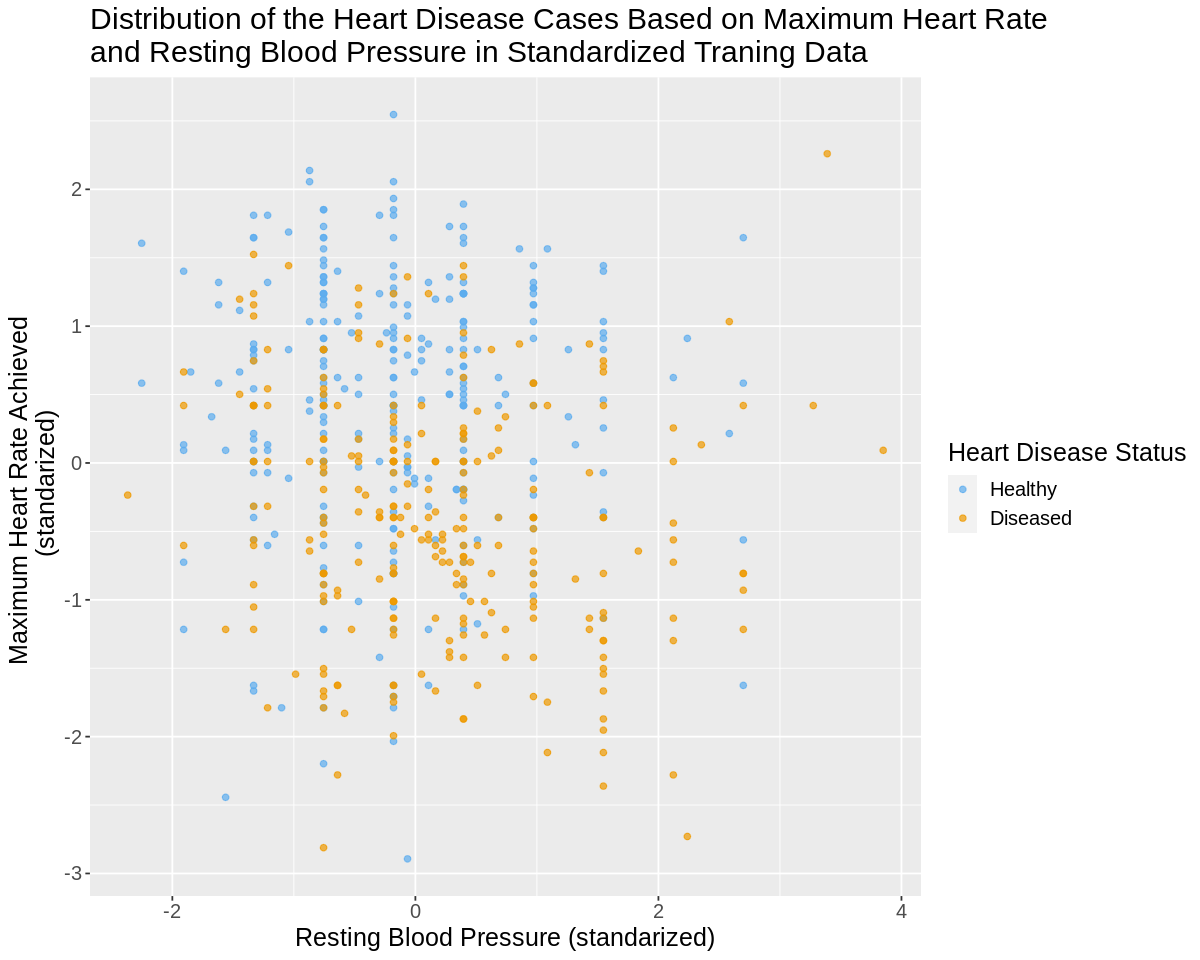

In [52]:
options(repr.plot.width = 10, repr.plot.height = 8) 
cholvshr <- ggplot(scaled_heart, aes(x = RestingBP, y = MaxHR, color = HeartDisease)) +
      geom_point(alpha = 0.7) +
      xlab("Resting Blood Pressure (standarized)") +
      ylab("Maximum Heart Rate Achieved \n (standarized)") +
      labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on Maximum Heart Rate \nand Resting Blood Pressure in Standardized Traning Data")
cholvshr

Figure 2: Scatter plot of maximum heart rate achieved versus resting blood pressure  colored by heart disease status label

In [53]:
explain the relationship and whta we expect

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain the
            ^


#### Determining the best k value (number of neighbors)

In [21]:
 explain this
explain cross fold chpsen to be 10 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1:  explain this
             ^


In [92]:
set.seed(123)

data_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors= seq(from= 1, to= 100, by= 5))

knn_result <- workflow()|>
    add_recipe(data_train_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=data_vfold, grid=k_vals)|>
    collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

maxmax<- accuracies|>
    filter(mean == max(mean))
maxmax

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
66,accuracy,binary,0.7066137,10,0.02241075,Preprocessor1_Model14


Table 5. The nubmer of neighbors (K-value) wiht the highest accuracy

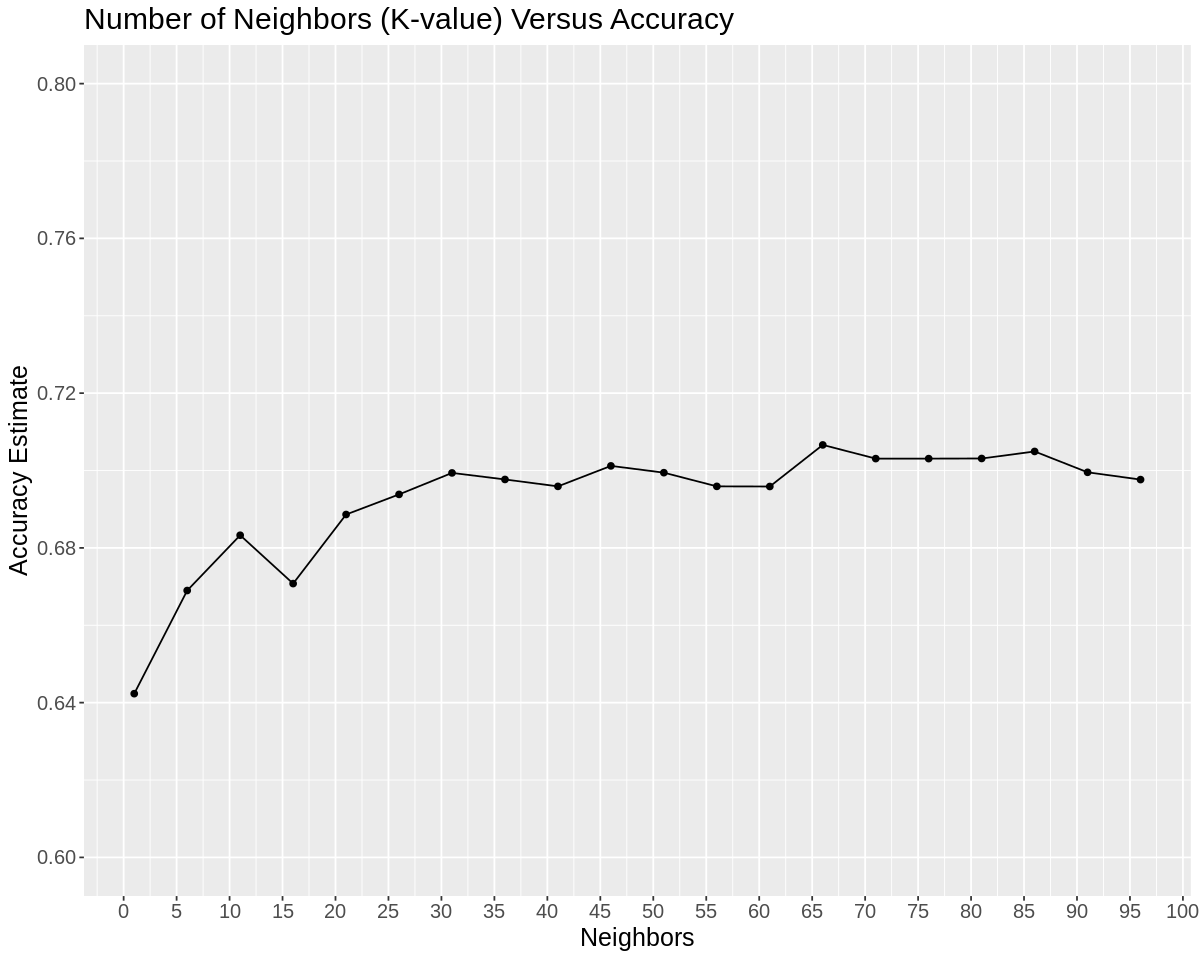

In [81]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 15))+
    scale_x_continuous(breaks = seq(0, 100, by = 5))+  
    scale_y_continuous(limits = c(0.6, 0.8), breaks=seq(0.6, 1, by=0.04))+
    ggtitle ("Number of Neighbors (K-value) Versus Accuracy")
accuracy_vs_k

Figure 3: Plot of estimated accuracy versus the number of neighbors (K-value)

Based on the information on Table 5 and Figure 3, setting the number of neighbors to K = 66 gives the highest accuracy (70.66%). Based on figure 3, values after k = 20 have a similar accuracy. Therefore, any selection from k= 20 to k= 95 can be reasonable but k = 66 is provides the highest accuracy. (Table 5 approves this result)


#### Finding the Accuracy of the Model Using K=66

In [84]:
set.seed(123)

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 66) |>
       set_engine("kknn") |>
       set_mode("classification")

mnist_fit <- workflow() |>
            add_recipe(data_train_recipe) |>
            add_model(mnist_spec) |>
            fit(data = heart_train)

mnist_predictions <- predict(mnist_fit, heart_test)|>
        bind_cols(heart_test)

mnist_predictions

.pred_class,Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,40,140,289,172,0
1,54,150,195,122,0
0,54,110,208,142,0
⋮,⋮,⋮,⋮,⋮,⋮
1,63,124,197,136,1
1,59,164,176,90,1
0,57,130,236,174,1


In [88]:
mnist_metrics <- mnist_predictions |>
        metrics(truth=HeartDisease, estimate = .pred_class) |>
        filter(.metric=="accuracy")|>
        select(.metric, .estimate)

mnist_metrics

.metric,.estimate
<chr>,<dbl>
accuracy,0.631016


In [ ]:
Table 6. 

For prediction of heart disease the accuracy of the 63.10% is not a very good value for this data. Heart disease is very seriouse disease and cause a lot of death yearly so the accuracy for prediction of this data should be high. Therefore, this result suggest that prediction with these variable is not sufficient; however, it is also important to check the confusion matrix. 

In [66]:
n_row <- nrow(data_heart)

data_percentage <- data_heart |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row*100)
data_percentage

HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,390,52.27882
1,356,47.72118


In [ ]:
Table 7.

In [67]:
compare 63 to 52 
explain how good our model is 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected numeric constant
1: compare 63
            ^


In [63]:
mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = HeartDisease, estimate = .pred_class)

mnist_conf_mat

          Truth
Prediction  0  1
         0 68 39
         1 30 50

In [ ]:
Table 8.

The confusion matrix displays 68 observations were correctly predicted as healthy and 50 were correctly predicted as diseased. However, it shows 39 patients as healthy while they were diseased and 30 patients was predicted as diseased while they wear healthy. Therefore, the classifier predicts 118 (68 + 50) observations correctly, and it determines 69 (30 + 39) observations mistakenly. As a result, this confusion matrix suggests this prediction is not very helpful as 39 patients with heart disease was mistakenly diagnosed as healthy, and they may not receive further tests and treatments which is dangerous.

question could be how accurate could we predit only with ata chest pain

## Discussion:

By developing this model, we expect to be able to predict heart disease, with a reasonable accuracy for application in healthcare, based on the biological determinants and symptoms observed in individuals. In particular, this model predicts the heart disease by taking some of the most important risk factors into consideration. It anticipates the presence, or the absence of the heart disease based on the combination of these numerical variables in a systemic approach, instead of relying on the personal judgement of a healthcare provider.
 Therefore, our model can lay the groundwork for designing a potential diagnostic tool assisting healthcare professionals to address life threatening heart diseases earlier and more accurately. 
Also, in our analysis, some relationships may be observed between heart disease and the predictors.
These observations can lead the researchers to answer further questions like what the physiological
mechanisms behind these relationships are. This model can be expanded by designing a model capable of predicting heart disease in individuals considering different types of chest pains and across different genders, which are the limitations of the current model.
One the possible reasons for the relatively low accuracy of this model can be the potential confounding effects between some of the predictors that we were not able to address due the limitations of the model or the dataset. For example, in Figure 1, we can see that there is no correlation between the cholesterol level and the heart disease, which is not consistent with what is known medically. Thus, maybe the negative effect of high cholesterol in heart diseases can be observed when it is considered along with the amount of exercise (not numerical) or stress levels (not available in the dataset).

In [30]:
should disscussion be here

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: should disscussion
           ^


## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

3.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

4.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
